In [1]:
pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00


In [2]:
pip install torch

In [10]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shap
from scipy.signal import istft

def audio_to_spectrogram(audio_path):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Create spectrogram using STFT
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    return S, S_db, sr, audio

def explain_spectrogram(S_db):
    # Flatten the spectrogram to 2D if needed
    original_shape = S_db.shape
    if S_db.ndim != 2:
        S_db = S_db.reshape(1, -1)

    # Create a simple model that works with flattened data
    def model(X):
        return np.mean(X, axis=1)

    # Create explainer with proper dimensionality
    background = np.zeros((1, S_db.shape[1]))
    explainer = shap.KernelExplainer(model, background)

    # Calculate SHAP values
    shap_values = explainer.shap_values(S_db)

    # Reshape back to original dimensions
    shap_values = np.array(shap_values).reshape(original_shape)

    return shap_values

def crop_spectrogram(S, shap_values, threshold=0.5):
    # Reshape shap_values to match spectrogram dimensions
    shap_values = np.resize(shap_values, S.shape)

    # Calculate importance scores
    importance = np.abs(shap_values).mean(axis=0)

    # Normalize importance scores
    importance = (importance - importance.min()) / (importance.max() - importance.min())

    # Create mask for important regions
    mask = importance < threshold

    # Broadcast mask to match spectrogram dimensions
    mask = np.broadcast_to(mask, S.shape)

    # Apply mask to spectrogram
    S_cropped = S.copy()
    S_cropped[~mask] = 0

    return S_cropped

def spectrogram_to_audio(S_cropped, sr):
    # Inverse STFT to get audio
    audio_reconstructed = librosa.istft(S_cropped)
    return audio_reconstructed
def process_and_explain_audio(audio_path, threshold=0.5):
    # Convert audio to spectrogram
    S, S_db, sr, original_audio = audio_to_spectrogram(audio_path)

    # Get SHAP explanations
    shap_values = explain_spectrogram(S_db)

    # Calculate importance scores
    importance = np.abs(shap_values).mean(axis=0)
    importance = (importance - importance.min()) / (importance.max() - importance.min())

    # Find time indices where gunshot occurs (above threshold)
    significant_times = np.where(importance > threshold)[0]
    if len(significant_times) > 0:
        # Convert frame indices to timestamps
        hop_length = 512  # Default hop length in librosa
        frame_time = hop_length / sr  # Time per frame in seconds

        # Calculate start and end times in seconds
        start_time = significant_times[0] * frame_time
        end_time = significant_times[-1] * frame_time

        # Convert to datetime64 timestamps
        base_time = np.datetime64('now')
        start_timestamp = base_time + np.timedelta64(int(start_time * 1000), 'ms')
        end_timestamp = base_time + np.timedelta64(int(end_time * 1000), 'ms')
    else:
        start_timestamp = end_timestamp = None

    # Crop spectrogram based on explanations
    S_cropped = crop_spectrogram(S, shap_values, threshold)

    # Convert back to audio
    audio_reconstructed = spectrogram_to_audio(S_cropped, sr)

    # Visualize results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Spectrogram')

    plt.subplot(2, 1, 2)
    S_cropped_db = librosa.amplitude_to_db(np.abs(S_cropped), ref=np.max)
    librosa.display.specshow(S_cropped_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Cropped Spectrogram')

    if start_timestamp and end_timestamp:
        print(f"Gunshot detected from {start_timestamp} to {end_timestamp}")
        print(f"Duration: {(end_time - start_time):.2f} seconds")

    plt.tight_layout()
    plt.show()

    return audio_reconstructed, sr, start_timestamp, end_timestamp

  0%|          | 0/1025 [00:00<?, ?it/s]

Gunshot detected from 2024-12-03T18:16:51.000 to 2024-12-03T18:16:54.018
Duration: 3.02 seconds


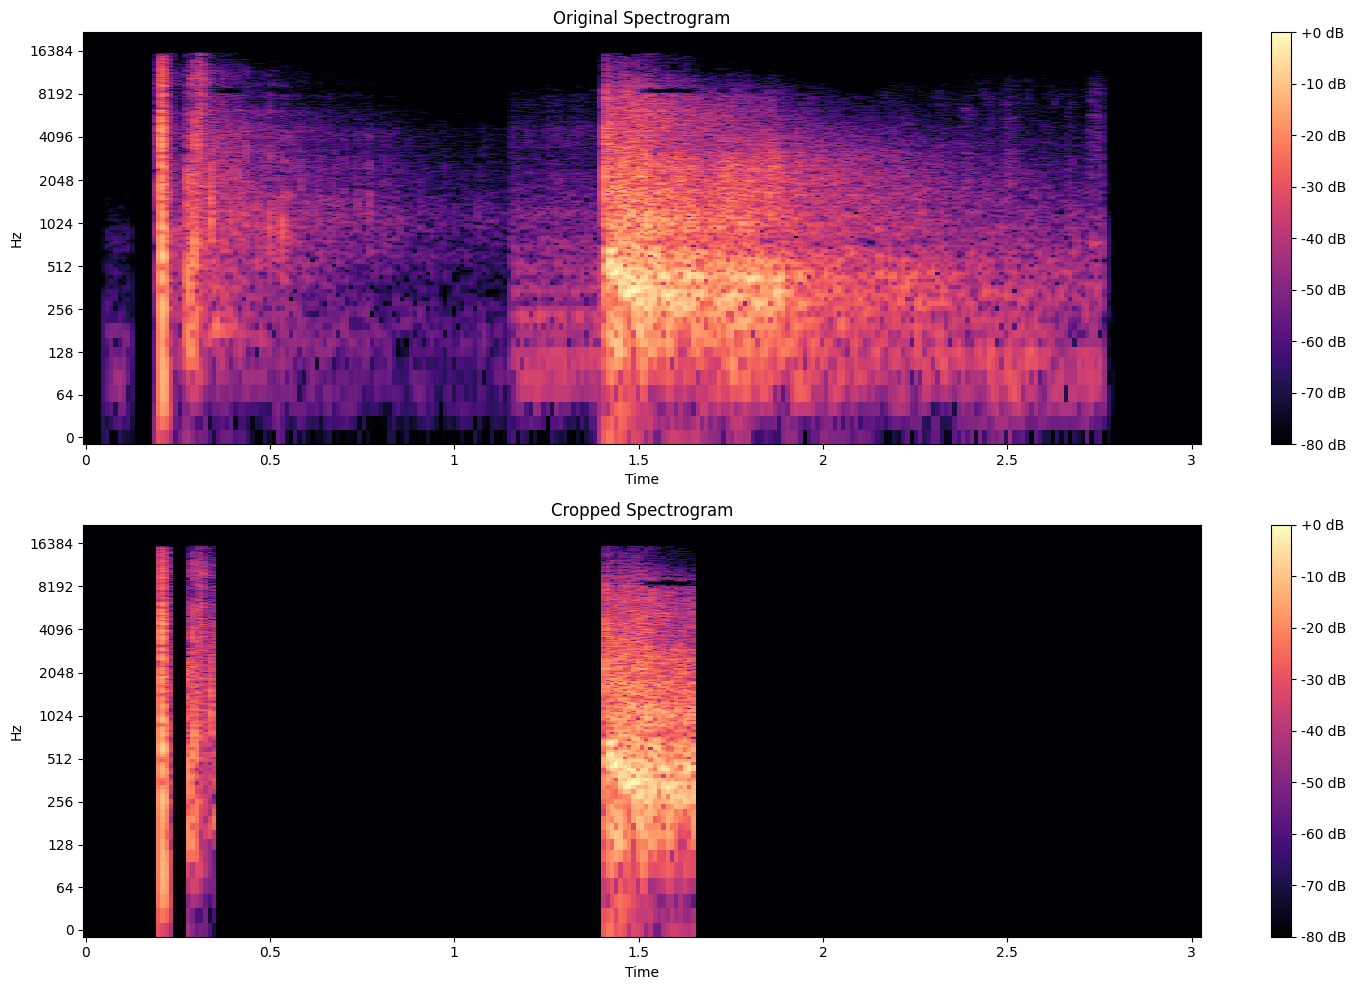

Start Timestamp: 2024-12-03T18:16:51.000
End Timestamp: 2024-12-03T18:16:54.018


In [11]:
# Save the reconstructed audio
import soundfile as sf
def explain_spectrogram(S_db):
    """Generate SHAP values for the spectrogram"""
    # Reshape the spectrogram if needed
    original_shape = S_db.shape
    if S_db.ndim != 2:
        S_db = S_db.reshape(1, -1)

    # Create a simple background distribution
    background = np.zeros((1, S_db.shape[1]))

    # Define a simple model for SHAP to explain
    def model(X):
        return np.mean(X, axis=1)

    # Create SHAP explainer
    explainer = shap.KernelExplainer(model, background)

    # Calculate SHAP values
    shap_values = explainer.shap_values(S_db)

    # Reshape back to original dimensions
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    shap_values = np.array(shap_values).reshape(original_shape)

    return shap_values

# Example usage
audio_path = "/content/gunVsFire.mp3"
#audio_reconstructed, sr = process_and_explain_audio(audio_path, threshold=0.5)
audio_reconstructed, sr, start_timestamp, end_timestamp = process_and_explain_audio(audio_path, threshold=0.5)
print(f"Start Timestamp: {start_timestamp}")
print(f"End Timestamp: {end_timestamp}")

# Save the reconstructed audio
sf.write('reconstructed_audio.wav', audio_reconstructed, sr, subtype='PCM_24')

In [6]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shap
from scipy.signal import istft

def audio_to_spectrogram(audio_path):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Create spectrogram using STFT
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    return S, S_db, sr, audio

def explain_spectrogram(S_db):
    # Flatten the spectrogram to 2D if needed
    original_shape = S_db.shape
    if S_db.ndim != 2:
        S_db = S_db.reshape(1, -1)

    # Create a simple model that works with flattened data
    def model(X):
        return np.mean(X, axis=1)

    # Create explainer with proper dimensionality
    background = np.zeros((1, S_db.shape[1]))
    explainer = shap.KernelExplainer(model, background)

    # Calculate SHAP values
    shap_values = explainer.shap_values(S_db)

    # Reshape back to original dimensions
    shap_values = np.array(shap_values).reshape(original_shape)

    return shap_values

def crop_spectrogram(S, shap_values, threshold=0.5):
    # Reshape shap_values to match spectrogram dimensions
    shap_values = np.resize(shap_values, S.shape)

    # Calculate importance scores
    importance = np.abs(shap_values).mean(axis=0)

    # Normalize importance scores
    importance = (importance - importance.min()) / (importance.max() - importance.min())

    # Create mask for important regions
    mask = importance < threshold

    # Broadcast mask to match spectrogram dimensions
    mask = np.broadcast_to(mask, S.shape)

    # Apply mask to spectrogram
    S_cropped = S.copy()
    S_cropped[~mask] = 0

    return S_cropped

def spectrogram_to_audio(S_cropped, sr):
    # Inverse STFT to get audio
    audio_reconstructed = librosa.istft(S_cropped)
    return audio_reconstructed
def process_and_explain_audio(audio_path, threshold=0.5):
    # Convert audio to spectrogram
    S, S_db, sr, original_audio = audio_to_spectrogram(audio_path)

    # Get SHAP explanations
    shap_values = explain_spectrogram(S_db)

    # Calculate importance scores
    importance = np.abs(shap_values).mean(axis=0)
    importance = (importance - importance.min()) / (importance.max() - importance.min())

    # Find time indices where gunshot occurs (above threshold)
    significant_times = np.where(importance > threshold)[0]
    if len(significant_times) > 0:
        # Convert frame indices to timestamps
        hop_length = 512  # Default hop length in librosa
        frame_time = hop_length / sr  # Time per frame in seconds

        # Calculate start and end times in seconds
        start_time = significant_times[0] * frame_time
        end_time = significant_times[-1] * frame_time

        # Convert to datetime64 timestamps
        base_time = np.datetime64('now')
        start_timestamp = base_time + np.timedelta64(int(start_time * 1000), 'ms')
        end_timestamp = base_time + np.timedelta64(int(end_time * 1000), 'ms')
    else:
        start_timestamp = end_timestamp = None

    # Crop spectrogram based on explanations
    S_cropped = crop_spectrogram(S, shap_values, threshold)

    # Convert back to audio
    audio_reconstructed = spectrogram_to_audio(S_cropped, sr)

    # Visualize results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Spectrogram')

    plt.subplot(2, 1, 2)
    S_cropped_db = librosa.amplitude_to_db(np.abs(S_cropped), ref=np.max)
    librosa.display.specshow(S_cropped_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Cropped Spectrogram')

    if start_timestamp and end_timestamp:
        print(f"Gunshot detected from {start_timestamp} to {end_timestamp}")
        print(f"Duration: {(end_time - start_time):.2f} seconds")

    plt.tight_layout()
    plt.show()

    return audio_reconstructed, sr, start_timestamp, end_timestamp

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


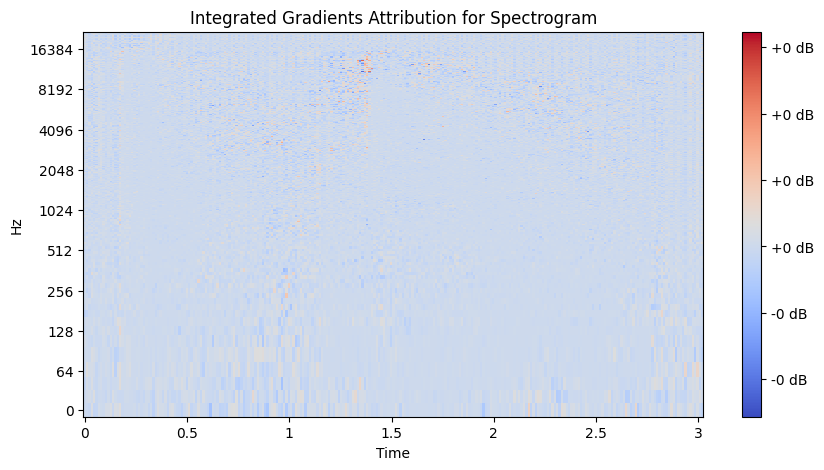

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from captum.attr import IntegratedGradients
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_path = '/content/gunVsFire.mp3'  # Provide the correct path
audio, sr = librosa.load(audio_path, sr=None)

# Generate the spectrogram
S = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(S))

# Convert the spectrogram to a PyTorch tensor and add batch and channel dimensions
input_tensor = torch.tensor(S_db, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
input_tensor.requires_grad = True  # Enable gradient calculation

# Normalize the spectrogram for the model (if needed, adjust based on your model)
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization, adjust for your model
])

input_tensor = transform(input_tensor)

# Load a pretrained ResNet model (modify for single-channel input)
model = models.resnet18(pretrained=True)

# Modify the first layer to accept a single-channel spectrogram
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Set the model to evaluation mode
model.eval()

# Get model prediction
output = model(input_tensor)

# Choose the predicted class (max probability)
predicted_class = output.argmax(dim=1)

# Apply Integrated Gradients
ig = IntegratedGradients(model)

# Create a baseline tensor (e.g., a tensor of zeros)
baseline = torch.zeros_like(input_tensor)

# Get the model's prediction and apply Integrated Gradients for the predicted class
attributions = ig.attribute(input_tensor, baseline, target=predicted_class)

# Squeeze to remove batch and channel dimensions
attributions = attributions.squeeze().detach().numpy()

# Visualize the attribution map (Integrated Gradients output)
plt.figure(figsize=(10, 5))
librosa.display.specshow(attributions, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Integrated Gradients Attribution for Spectrogram')
plt.show()
